In [8]:
# basic imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

Based on remapping the SRD distributions to alpha = 0.92,
    $z0$ parameter of z distribution vs i limiting magnitude $ilim$ is:
 $z0 = 0.246 + 0.025*(ilim-24.1)$

In [9]:
# First, we are going to create Monte Carlo samples from the SRD
# distributions of i magnitude and p(z | i)

# set up to make interpolation tables
# can change the i magnitude range of objects or the z
# range to consider in this cell
imin = 17
imax= 27
ni = 101
deltai = (imax-imin)/(ni-1)

zmin = 0
zmax = 4
nz = 401
deltaz = (zmax-zmin)/(nz-1)

ival=np.linspace(imin,imax,ni)
z=np.linspace(zmin,zmax,nz)

# these grids are for interpolation tables
# that I didn't get to work
#ivals,zvals = np.meshgrid(ival,z)
#z0s = 0.246 + 0.025*(ivals-24.1)


In [10]:
# generate a normalized cumulative distribution 
# corresponding to n(<i) from the SRD
# for the Monte Carlo we want the values to run from 0 to 1

n_of_i = 42.9*0.88*10**(0.359*(ival-25))
n_of_i = n_of_i / n_of_i[ni-1]

In [11]:
#needed the below for %%timeit to work and the slow generation step not to be even slower due to error messages

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [12]:
# some more imports we'll need soon
import pandas
from photerr import LsstErrorModel
import os.path

filename = 'saved_catalog.feather'
# if generate = True we will calculate new monte carlo for distribution in i and redshift;
# if generate = False then we will use an existing file
generate = False

# double-check that file actually exists, if not we will generate it no matter what

if (os.path.isfile(filename) == False):
    generate = True 

if generate:
    # number of objects to generate.  Need >>1M looks like
    n_mc = 30_000_000

# generate random true i magnitudes up to imax following the 
# distribution calculated in the above cell
    true_i = np.interp(np.random.random_sample(n_mc),n_of_i,ival)

# array to contain the true redshift for each MC object
    true_z = np.zeros_like(true_i)

#based on the drawn i magnitude for each object,
#   draw a random z from p(z,i)
# i was hoping to avoid calculating all this for every
# object but failed to get interpolation to work.  This 
# does ok but is a bit slower than i'd like

    for idx,imag in enumerate(true_i):
        z0 = 0.246 + 0.025*(imag-24.1)
        dndi = (0.868296*10**(0.359*(imag-25))
         *np.exp(-(z/z0)**0.92)*z**3)/( (z0**2)*(z/z0)**0.08) 
        dndi += 31.2069*10**(0.359*(imag-25))*np.exp(-(z/z0)**0.92)*z**2
        dndi[np.isfinite(dndi) == 0] = 0.
    
        cdndi = np.cumsum(dndi)
        cdndi = cdndi / cdndi[nz-1]
        true_z[idx] = np.interp(np.random.random_sample(1),
          cdndi,z)
    d= {'i':true_i,'zarr':true_z}
    catalog = pandas.DataFrame(data=d)
    
    catalog.to_feather(filename)
else:
    catalog = pandas.read_feather(filename)

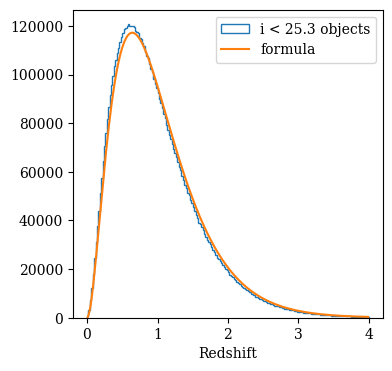

In [13]:
#check redshift distributions

imag=25.3
z0 = 0.246 + 0.025*(imag-24.1)

zdist = catalog[catalog['i'] < 25.3]['zarr']
n,bins,edges = plt.hist(zdist,bins=200,histtype = 'step',label='i < 25.3 objects')

z=(bins[0:-1]+bins[1:])/2.
zdist = z**2*np.exp(-(z/z0)**0.92)
plt.plot(z,zdist*np.sum(n)/np.sum(zdist),label='formula')
plt.xlabel('Redshift')
plt.legend()

#this looks very slightly off, maybe due to plotting curve at bin center 
# vs. integrating over bin? Regardless seems good enough for what we are doing

In [14]:
# set up grid of 5 sigma depths to consider

m5s = np.linspace(25.75,28.25,26)

In [17]:
# Need to  apply flux errors for different 
# depths as a function of true i magnitude. 

# note error in magnitude = 2.5/ln(10)*(sigma_f/f)

summary_filename = 'results.feather'

# if you want better statistics, we can generate more realizations of the noise.  
# Since we are interested in shifts only, keeping the monte carlo the same but 
# generating more noise realizations should be fine

# nreplicate should be an integer
# avoid it for now: I ran out of memory running with it set to 4
nreplicate = 1

if nreplicate > 1:
    catalog_rep = pandas.concat([catalog]*nreplicate, ignore_index=True)
else:
    catalog_rep = catalog.copy()

meanz_253 = np.zeros_like(m5s)
meanz_253_error = np.zeros_like(m5s)

number_253 = np.zeros_like(m5s)
number_253_error = np.zeros_like(m5s)

true_z = catalog_rep['zarr']
true_i = catalog_rep['i']

for idx,m5 in enumerate(m5s):
    errModel = LsstErrorModel(nYrObs=1,nVisYr={'i':1},m5={'i':float(m5)})
    tmpcatalog = errModel(catalog_rep, 
      random_state=np.random.randint(1,100_000))
    fluxes = 10**(-0.4*(tmpcatalog['i'] - 27))
    fluxerrs = tmpcatalog['i_err']*np.log(10)/2.5*fluxes
    noisy_i_flux = fluxes + fluxerrs*np.random.normal(size=tmpcatalog.count()[0])
    # don't let fluxes go negative: limit corresponds to magnitude = 32
    noisy_i_flux = np.maximum(noisy_i_flux, 0.01)
    noisy_i = 27 - 2.5*np.log10(noisy_i_flux)
    meanz_253[idx] = np.mean(tmpcatalog[noisy_i < 25.3]['zarr'])
    number_253[idx] = np.sum(noisy_i < 25.3)
    meanz_253_error[idx] = np.std(tmpcatalog[noisy_i < 25.3]['zarr'])/np.sqrt(number_253[idx])
    number_253_error[idx] = np.sqrt(number_253[idx])

meanz_253_true = np.mean(catalog_rep[true_i < 25.3]['zarr'])
number_253_true = np.sum(true_i < 25.3)


d= {'true_meanz':meanz_253_true,'true_n':number_253_true,'m5':m5s,'meanz':meanz_253,
     'number': number_253, 'meanz_err':meanz_253_error,'number_err':number_253_error }
outputs = pandas.DataFrame(data=d)

outputs.to_feather(summary_filename)

Text(0, 0.5, '$\\Delta$ <z>')

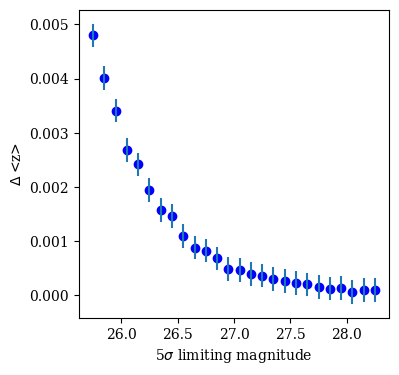

In [31]:
plt.plot(outputs['m5'],outputs['meanz']-outputs['true_meanz'],'bo')
plt.errorbar(outputs['m5'],outputs['meanz']-outputs['true_meanz'],outputs['meanz_err'],
            fmt='none')
plt.xlabel(r'5$\sigma$ limiting magnitude')
plt.ylabel(r'$\Delta$ <z>')

Text(0, 0.5, '$\\Delta \\Sigma / \\Sigma$')

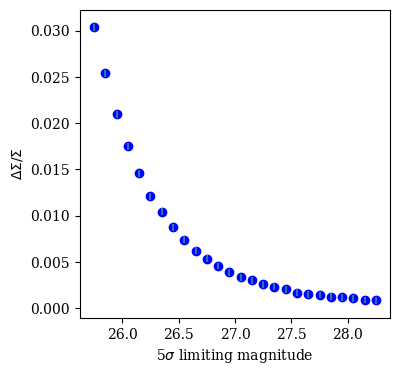

In [36]:
plt.plot(outputs['m5'],outputs['number']/outputs['true_n'] - 1,'bo')
plt.errorbar(outputs['m5'],outputs['number']/outputs['true_n'] - 1,outputs['number_err']/outputs['true_n'],
            fmt='none')
plt.xlabel(r'5$\sigma$ limiting magnitude')
plt.ylabel(r'$\Delta \Sigma / \Sigma$')

In [18]:
# example calculations

print(f'true photometry <z>: {np.mean(true_z[true_i < 25.3]):.4f}')
print(f'noisy photometry <z>: {np.mean(true_z[noisy_i < 25.3]):.4f}')
print(f'delta <z>: {np.mean(true_z[noisy_i < 25.3]) - np.mean(true_z[true_i < 25.3]):.4f}')
print(f'error on delta <z>: {np.sqrt(2)*np.std(true_z[true_i < 25.3])/np.sqrt(np.sum(true_i < 25.3)):.4f}')


true photometry <z>: 0.9733
noisy photometry <z>: 0.9734
delta <z>: 0.0001
error on delta <z>: 0.0003


In [19]:
print(f'true # of objects: {np.sum(true_i < 25.3):.5g}')
print(f'noisy # of objects: {np.sum(noisy_i < 25.3):.5g}')
print(f'fractional change: {(np.sum(noisy_i < 25.3) - np.sum(true_i < 25.3))/np.sum(true_i < 25.3):.4f}')
print(f'error on fractional change: {np.sqrt(np.sum(noisy_i < 25.3) + np.sum(true_i < 25.3))/np.sum(true_i < 25.3):.4f}')

true # of objects: 7.3582e+06
noisy # of objects: 7.3643e+06
fractional change: 0.0008
error on fractional change: 0.0005


In [ ]:
# ~1 sec to generate 10k MCs

# ~10 sec to add noise and calculate statistics for 1 choice of depth, 30M MCs


In [135]:
import os.path
filename = 'saved_catalog.feather'

if (os.path.isfile(filename) == False):
    generate = True 
    
print(generate)

False


In [134]:
generate = False

# Various code from when I was playing with things is below, kept in case you want to check intermediate steps

In [ ]:
# ignore this
# didn't get interpolation to work, let's not calculate this
# for now
if 0:
    dndis = (0.868296*10**(0.359*(ivals-25))
         *exp(-(zvals/z0s)**0.92)*zvals**3)/( (z0s**2)*(zvals/z0s)**0.08) 

    dndis += 31.2069*10**(0.359*(ivals-25))*exp(-(zvals/z0s)**0.92)*zvals**2
    dndis[np.isfinite(dndis) == 0] = 0.

    cumzdist = np.zeros_like(dndis)

    cumzdist = np.cumsum(dndis,axis = 0)
    for i in arange(ni):
        cumzdist[:,i]=cumzdist[:,i]/cumzdist[nz-1,i]

In [76]:
#ignore this

#nyears = 10.0
#nvisits_i = 18.4

# nominal depth from ivezic et al. 2018
#nominal_depth = 23.92+2.5*np.log10(nyears*nvisits_i)/2.
#m5_nominal = np.min(catalog_with_errors[ 
#      catalog_with_errors['i_err'] > 0.2*2.5/np.log(10)]['i'])

# make a grid in number of years, 
#    and calculate the corresponding m5 values
#nyears = np.logspace(np.log10(2),np.log10(50),21)
#m5s = m5_nominal +2.5*np.log10(nyears/10.)/2.

In [10]:
alpha_mid = 0.92
z0_mid = 1
intz3_mid = 1/alpha_mid*z0_mid**4*sp.special.gamma(4/alpha_mid)
intz2_mid = 1/alpha_mid*z0_mid**3*sp.special.gamma(3/alpha_mid)
znorm_mid=intz3_mid/intz2_mid

In [7]:
# you can safely ignore all this stuff --
# the next few cells are just figuring how to remap the SRD 
# redshift distributions to use fixed alpha=0.92 instead
# of alphas of 0.9 and 0.94, keeping mean z the same

alpha10 = 0.9
z0_10 = 0.28
intz3_y10 = 1/alpha10*z0_10**4*sp.special.gamma(4/alpha10)
intz2_y10 = 1/alpha10*z0_10**3*sp.special.gamma(3/alpha10)
zavg_10=intz3_y10/intz2_y10
znorm_10 = zavg_10/z0_10

In [8]:
alpha1 = 0.94
z0_1 = 0.26
intz3_y1 = 1/alpha1*z0_1**4*sp.special.gamma(4/alpha1)
intz2_y1 = 1/alpha1*z0_1**3*sp.special.gamma(3/alpha1)
zavg_1=intz3_y1/intz2_y1
znorm_1 = zavg_1/z0_1

In [11]:
# equivalent z0 values for fixed alpha = 0.92
z0_1m = z0_1*znorm_1 / znorm_mid
z0_10m = z0_10*znorm_10 / znorm_mid

In [13]:
# calculated the derivative of SRD n(<i,z) with respect to i
# limiting magnitude using Wolfram alpha.  The below is example 
# code that calculates the distribution of z at magnitude 
# ival (rather than for i < ival)

z=np.linspace(0,4,401)
ival=24.1
z0 = 0.246 + 0.025*(ival-24.1)

# tested this vs. the differential
# redshift distribution for a small delta-z, looks good

dndi = (0.868296*10**(0.359*(ival-25))
         *np.exp(-(z/z0)**0.92)*z**3)/( (z0**2)*(z/z0)**0.08) 

dndi += 31.2069*10**(0.359*(ival-25))*np.exp(-(z/z0)**0.92)*z**2
dndi[0]=0.

# note: the warning you get is due to a NaN at z = 0, 
# which this code fixes

/var/folders/15/b92d0zld655f8g95h7_482c40000gt/T/ipykernel_49940/4147977768.py:13: RuntimeWarning: invalid value encountered in divide
  dndi = (0.868296*10**(0.359*(ival-25))
